## BÀI THỰC HÀNH TH07

## NGUYỄN MINH HOÀNG 18110095

# Bài tập


## 1. Dựa vào mô hình GAN ở trên hãy tạo ra một mô hình DCGAN và train trên tập Mnist

**GENERATOR**

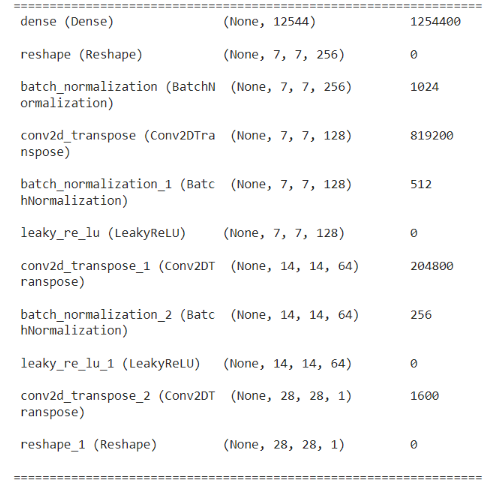

**DISCRIMINATOR**


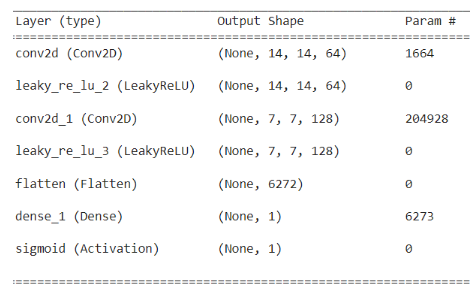

In [ ]:
!pip install ipyplot

In [ ]:

import ipyplot
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import(Dense, Reshape, BatchNormalization,
                                    Conv2DTranspose,LeakyReLU,Input,
                                    Conv2D, Flatten, Activation )




        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [ ]:
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
all_digits = (all_digits.astype("float32")-127.5) / 127.5 #đưa tấm hình về [-1,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
dataset=tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
generator = keras.Sequential(name = "generator")

generator.add(Input(shape=(100,)))

generator.add(Dense(units=7*7*256,
                          use_bias=False))
generator.add(Reshape((7,7,256)))

generator.add(BatchNormalization())

generator.add(Conv2DTranspose(filters=128,
                                           kernel_size=[5,5],
                                           strides=(1,1),
                                           padding="same",
                                           use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(filters=64,
                                           kernel_size=[5,5],
                                           strides=(2,2),
                                           padding="same",
                                           use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(filters=1,
                                           kernel_size=[5,5],
                                           strides=(2,2),
                                           padding="same",
                                           use_bias=False,
                                           activation="tanh"))
generator.add(Reshape((28,28,1)))


generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                         

In [ ]:
discriminator=keras.Sequential(name = "discriminator")
discriminator.add(Input((28,28,1)))
discriminator.add(Conv2D(filters=64,
                                             kernel_size=[5,5],
                                             strides=[2,2],
                                             padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(filters=128,
                                             kernel_size=[5,5],
                                             strides=[2,2],
                                             padding="same"))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Flatten())

discriminator.add(Dense(units=1))
discriminator.add(Activation(activation="sigmoid",name="sigmoid"))

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
 sigmoid (Activation)        (None, 1)               

In [ ]:
class Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Gan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(Gan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn
        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator(random_latent_vectors)
        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ở đây đánh nhãn ảnh thật là 0, ảnh giả là 1
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator

        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 1 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # return {"d_loss": d_loss, "g_loss": g_loss}

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }



In [ ]:
#overwrite callback để lúc huấn luyện xem ảnh in ra
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #Tạo noises
        generated_images = self.model.generator(random_latent_vectors) #tạo ảnh
        generated_images = generated_images*127.5+127.5 #Đưa ảnh về [0,255]
        generated_images.numpy() 
        list_img = []
        for i in range(self.num_img):
            # img = keras.preprocessing.image.array_to_img(generated_images[i])
            img = np.squeeze(generated_images[i], axis=2)
            list_img.append(img)
            # display(img) #in ảnh

        ipyplot.plot_images(list_img)

Epoch 1/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5907 - g_loss: 1.0205


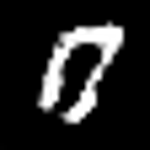
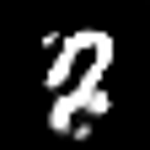
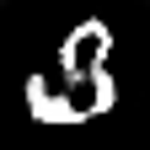
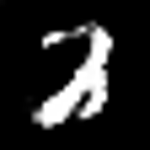


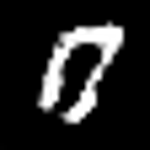
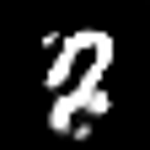
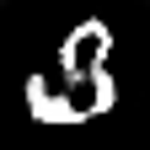
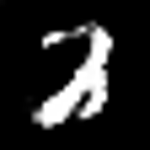

547/547 [==============================] - 51s 74ms/step - d_loss: 0.5907 - g_loss: 1.0205
Epoch 2/50
547/547 [==============================] - ETA: 0s - d_loss: 0.6297 - g_loss: 0.9696


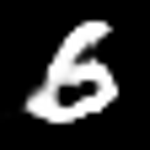
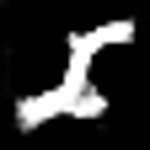
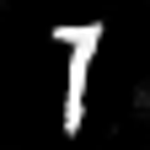
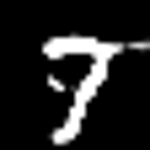


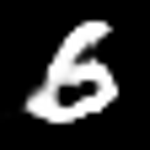
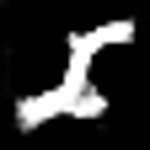
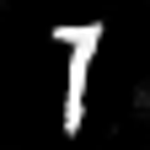
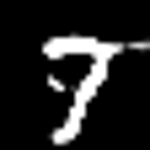

547/547 [==============================] - 40s 74ms/step - d_loss: 0.6297 - g_loss: 0.9696
Epoch 3/50
547/547 [==============================] - ETA: 0s - d_loss: 0.6316 - g_loss: 0.9290


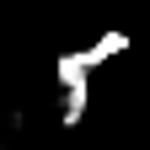
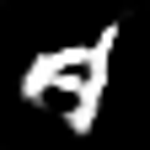
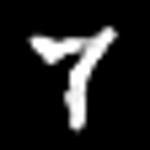
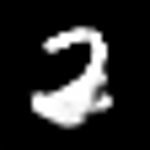


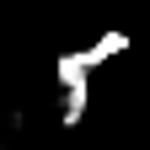
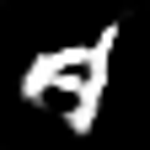
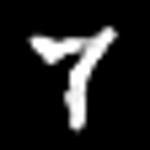
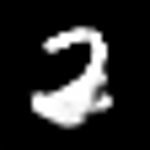

547/547 [==============================] - 40s 73ms/step - d_loss: 0.6316 - g_loss: 0.9290
Epoch 4/50
547/547 [==============================] - ETA: 0s - d_loss: 0.6153 - g_loss: 0.9508


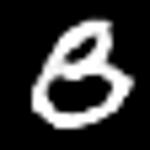
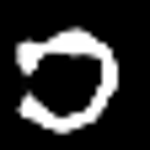
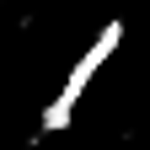
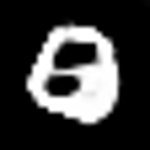


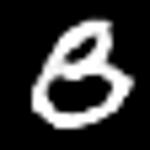
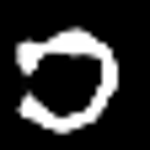
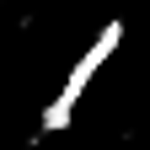
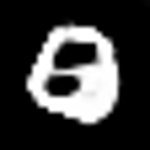

547/547 [==============================] - 40s 73ms/step - d_loss: 0.6153 - g_loss: 0.9508
Epoch 5/50
547/547 [==============================] - ETA: 0s - d_loss: 0.6102 - g_loss: 0.9934


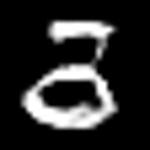
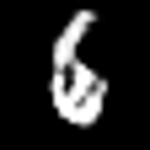
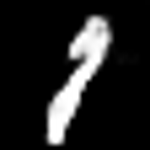
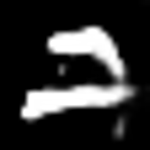


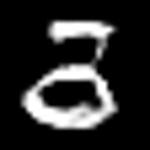
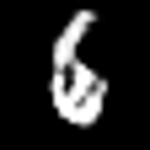
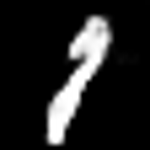
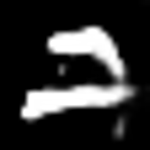

547/547 [==============================] - 40s 74ms/step - d_loss: 0.6102 - g_loss: 0.9934
Epoch 6/50
547/547 [==============================] - ETA: 0s - d_loss: 0.6062 - g_loss: 0.9885


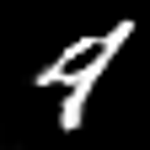
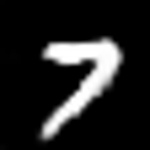
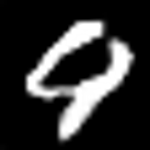
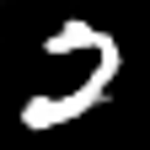


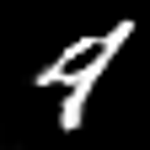
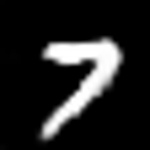
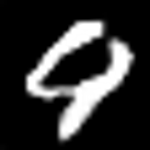
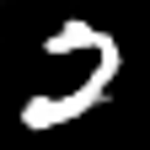

547/547 [==============================] - 40s 74ms/step - d_loss: 0.6062 - g_loss: 0.9885
Epoch 7/50
547/547 [==============================] - ETA: 0s - d_loss: 0.6022 - g_loss: 1.0408


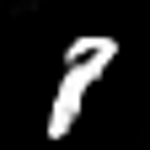
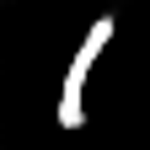
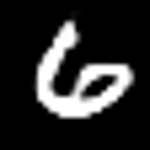
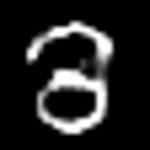


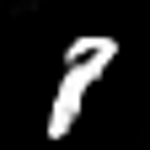
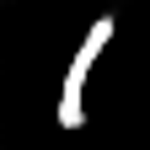
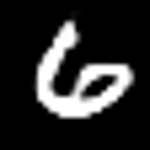
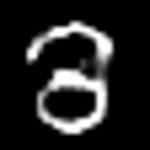

547/547 [==============================] - 41s 74ms/step - d_loss: 0.6022 - g_loss: 1.0408
Epoch 8/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5948 - g_loss: 1.0201


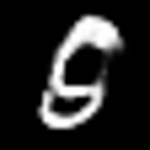
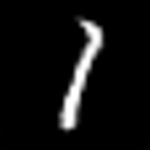
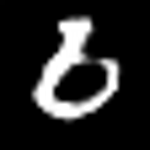
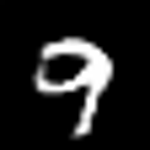


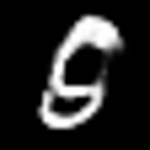
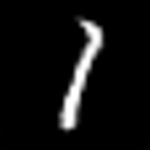
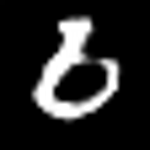
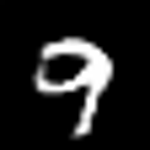

547/547 [==============================] - 41s 74ms/step - d_loss: 0.5948 - g_loss: 1.0201
Epoch 9/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5860 - g_loss: 1.0435


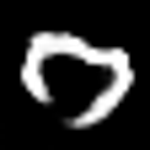
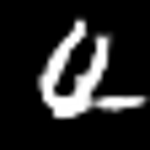
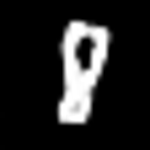
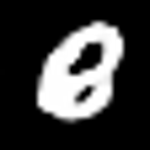


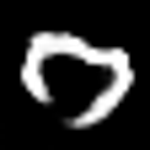
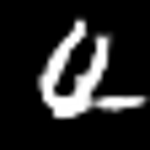
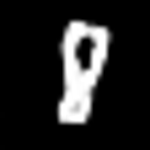
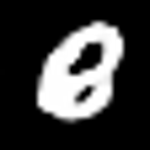

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5860 - g_loss: 1.0435
Epoch 10/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5799 - g_loss: 1.0989


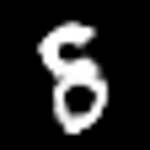
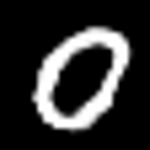
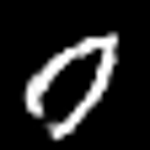
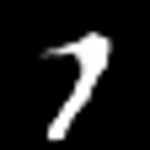


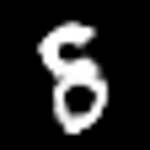
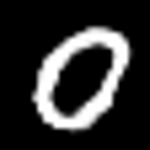
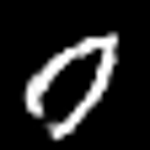
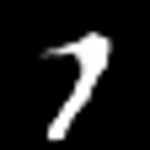

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5799 - g_loss: 1.0989
Epoch 11/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5728 - g_loss: 1.0962


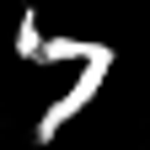
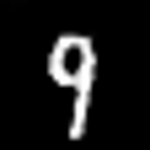
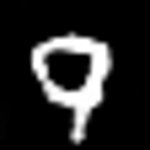
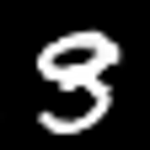


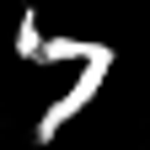
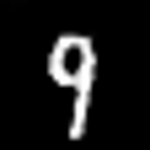
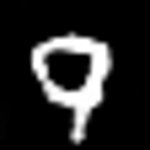
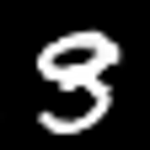

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5728 - g_loss: 1.0962
Epoch 12/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5688 - g_loss: 1.1285


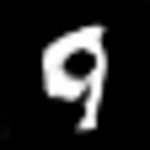
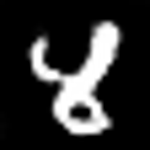
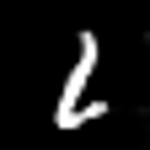
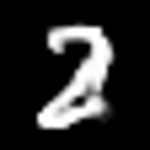


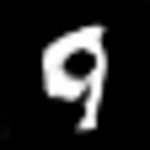
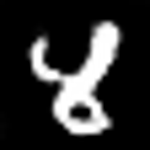
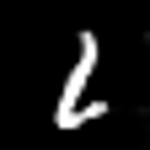
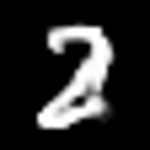

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5688 - g_loss: 1.1285
Epoch 13/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5635 - g_loss: 1.1348


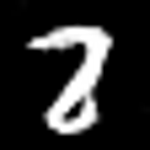
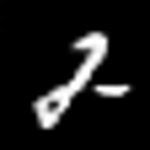
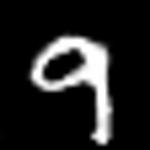
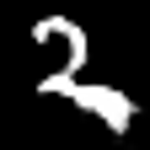


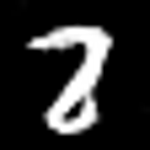
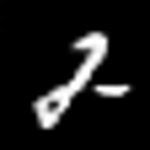
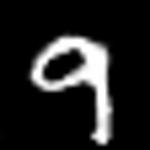
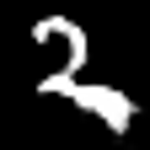

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5635 - g_loss: 1.1348
Epoch 14/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5572 - g_loss: 1.1465


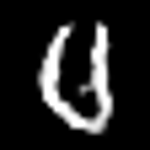
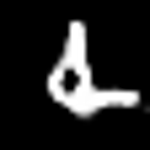
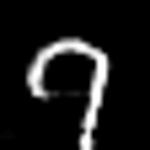
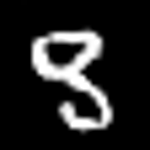


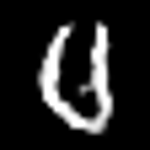
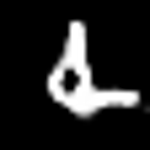
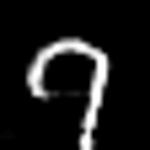
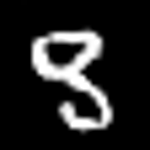

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5572 - g_loss: 1.1465
Epoch 15/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5538 - g_loss: 1.1684


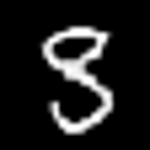
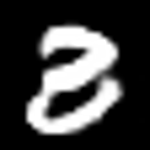
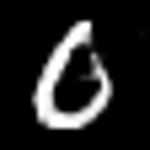
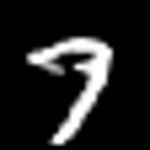


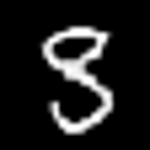
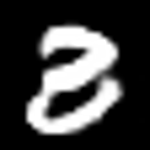
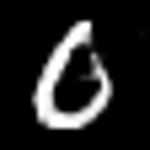
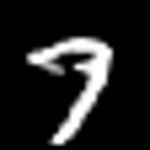

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5538 - g_loss: 1.1684
Epoch 16/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5488 - g_loss: 1.1846


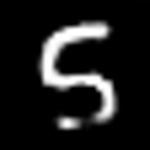
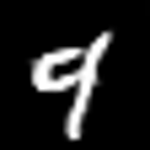
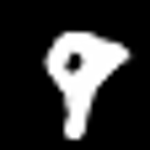
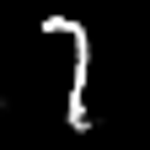


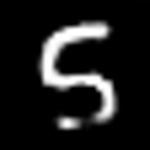
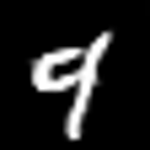
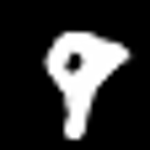
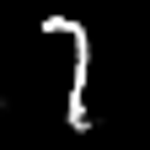

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5488 - g_loss: 1.1846
Epoch 17/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5460 - g_loss: 1.2038


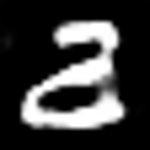
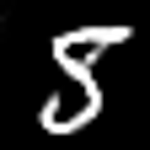
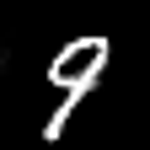
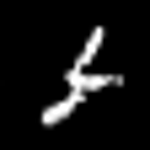


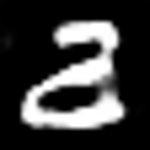
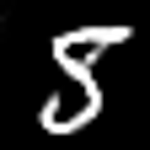
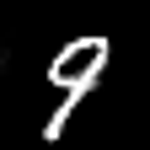
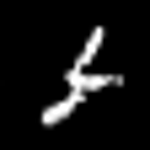

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5460 - g_loss: 1.2038
Epoch 18/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5441 - g_loss: 1.2172


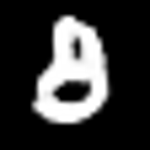
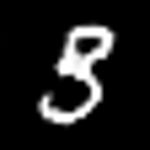
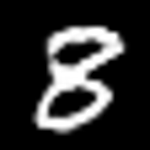
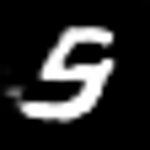


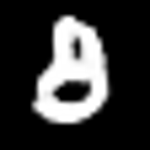
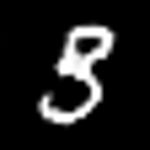
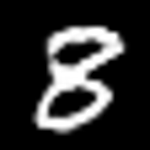
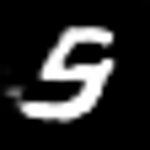

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5441 - g_loss: 1.2172
Epoch 19/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5381 - g_loss: 1.2292


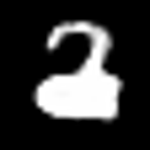
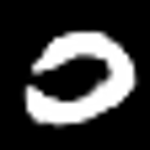
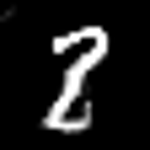
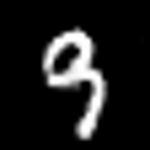


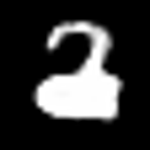
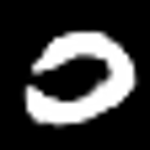
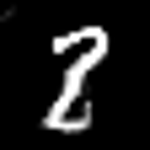
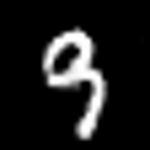

547/547 [==============================] - 41s 74ms/step - d_loss: 0.5381 - g_loss: 1.2292
Epoch 20/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5401 - g_loss: 1.2492


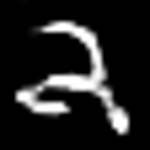
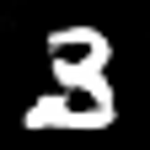
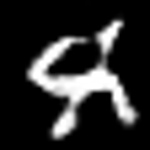
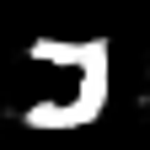


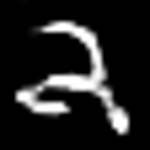
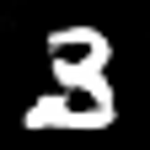
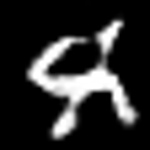
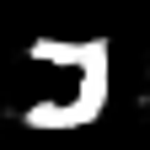

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5401 - g_loss: 1.2492
Epoch 21/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5371 - g_loss: 1.2518


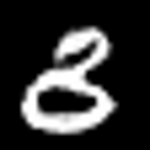
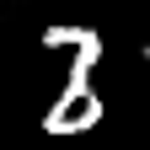
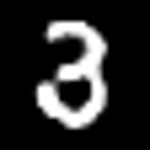
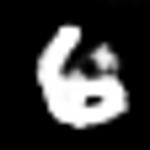


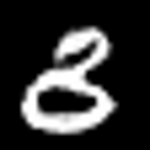
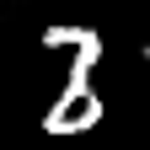
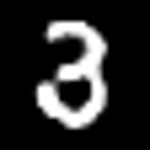
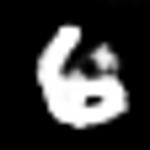

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5371 - g_loss: 1.2518
Epoch 22/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5341 - g_loss: 1.2636


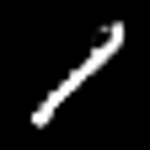
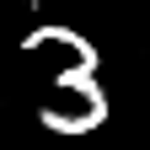
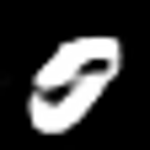
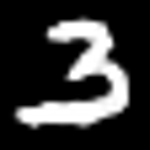


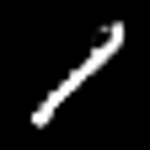
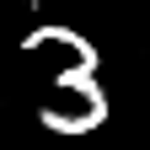
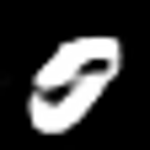
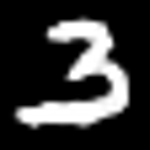

547/547 [==============================] - 41s 74ms/step - d_loss: 0.5341 - g_loss: 1.2636
Epoch 23/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5312 - g_loss: 1.2852


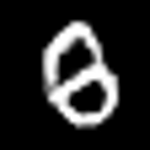
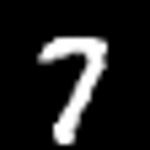
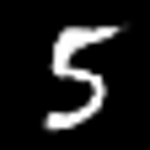
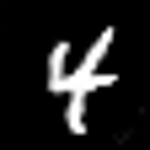


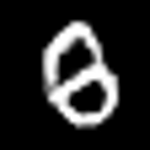
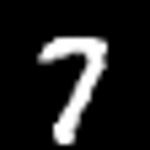
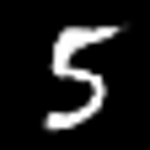
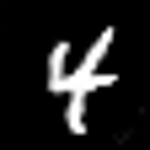

547/547 [==============================] - 41s 74ms/step - d_loss: 0.5312 - g_loss: 1.2852
Epoch 24/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5279 - g_loss: 1.2777


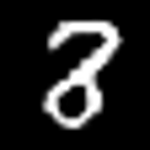
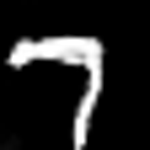
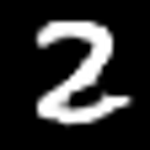
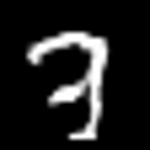


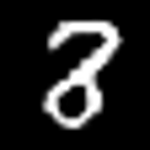
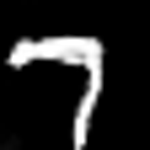
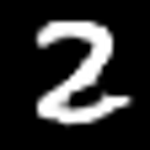
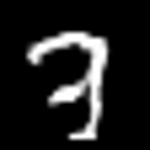

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5279 - g_loss: 1.2777
Epoch 25/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5267 - g_loss: 1.3029


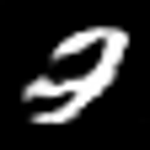
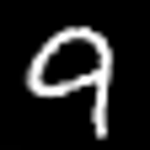
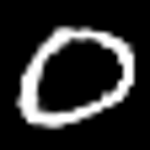
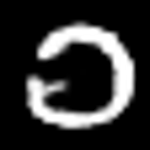


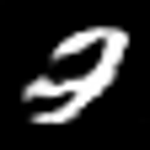
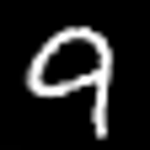
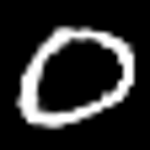
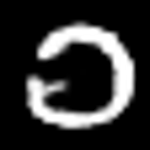

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5267 - g_loss: 1.3029
Epoch 26/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5240 - g_loss: 1.3048


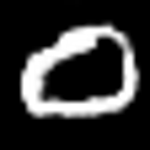
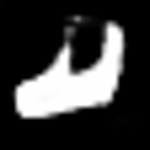
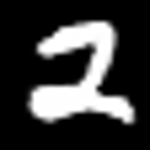
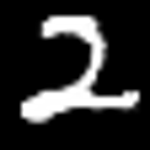


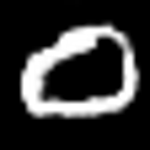
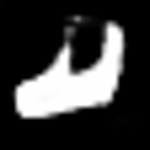
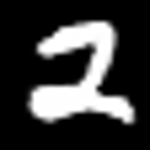
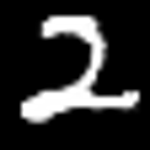

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5240 - g_loss: 1.3048
Epoch 27/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5264 - g_loss: 1.3258


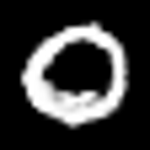
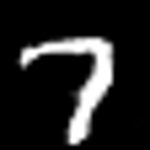
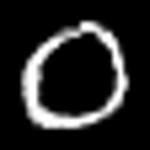
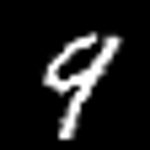


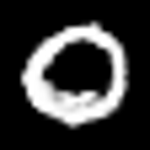
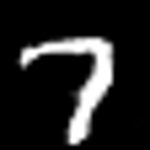
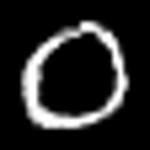
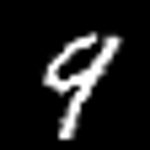

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5264 - g_loss: 1.3258
Epoch 28/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5196 - g_loss: 1.3326


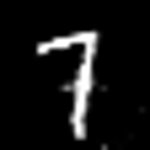
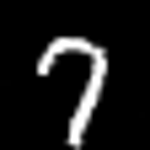
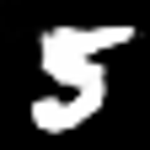
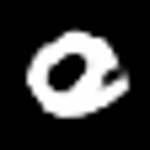


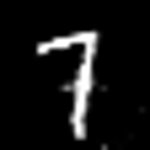
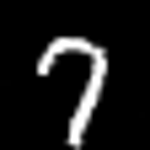
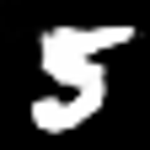
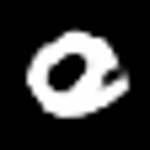

547/547 [==============================] - 41s 74ms/step - d_loss: 0.5196 - g_loss: 1.3326
Epoch 29/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5183 - g_loss: 1.3409


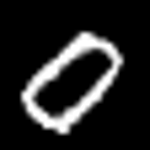
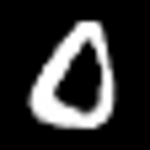
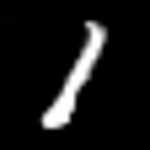
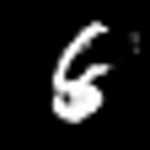


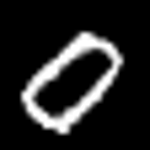
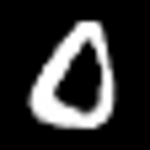
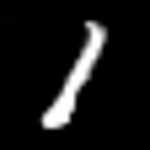
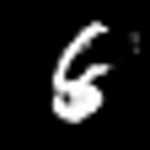

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5183 - g_loss: 1.3409
Epoch 30/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5170 - g_loss: 1.3526


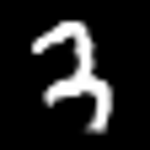
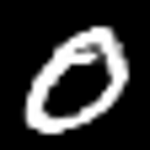
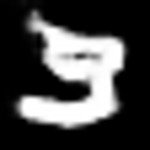
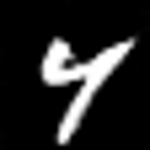


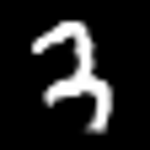
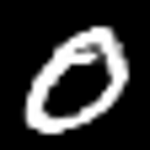
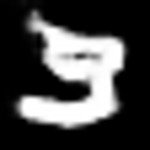
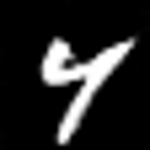

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5170 - g_loss: 1.3526
Epoch 31/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5172 - g_loss: 1.3578


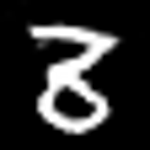
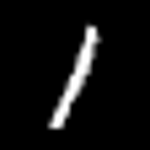
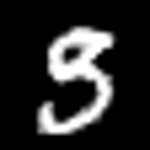
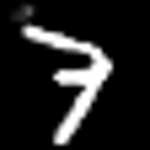


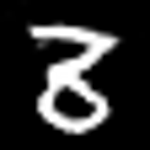
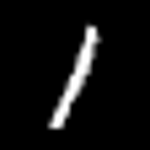
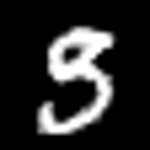
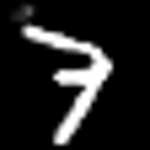

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5172 - g_loss: 1.3578
Epoch 32/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5100 - g_loss: 1.3644


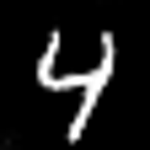
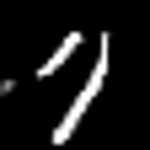
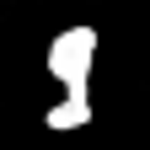
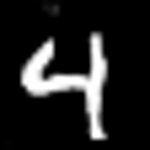


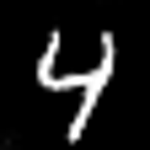
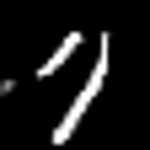
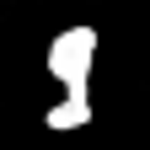
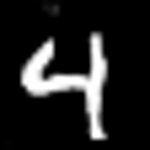

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5100 - g_loss: 1.3644
Epoch 33/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5084 - g_loss: 1.3728


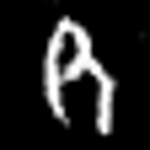
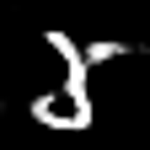
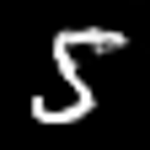
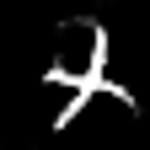


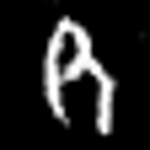
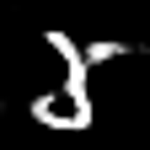
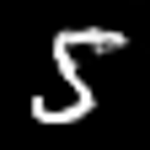
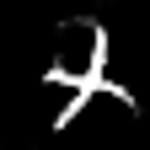

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5084 - g_loss: 1.3728
Epoch 34/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5087 - g_loss: 1.3937


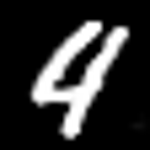
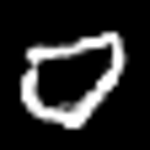
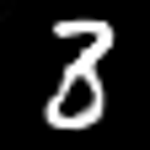
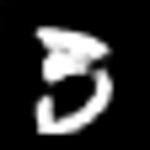


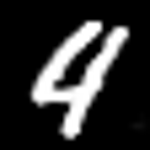
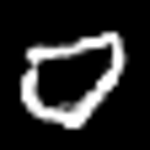
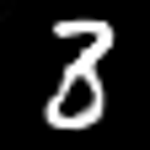
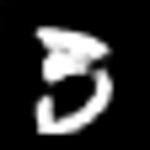

547/547 [==============================] - 41s 74ms/step - d_loss: 0.5087 - g_loss: 1.3937
Epoch 35/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5069 - g_loss: 1.4088


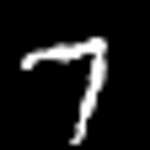
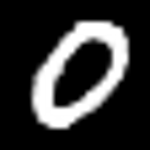
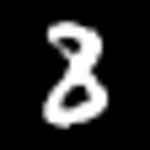
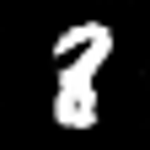


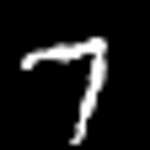
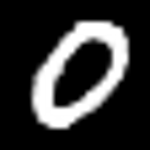
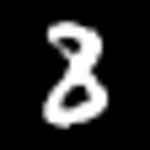
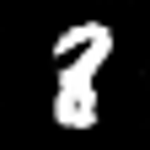

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5069 - g_loss: 1.4088
Epoch 36/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5018 - g_loss: 1.4102


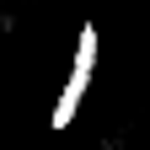
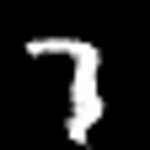
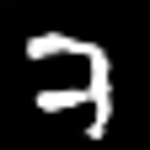
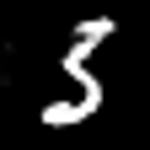


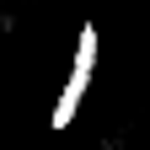
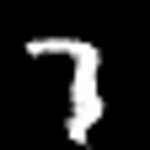
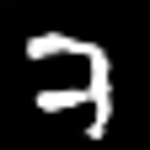
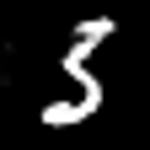

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5018 - g_loss: 1.4102
Epoch 37/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4982 - g_loss: 1.4083


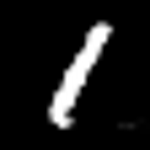
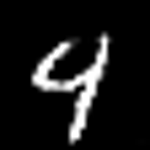
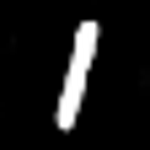
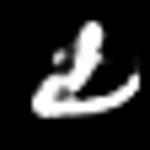


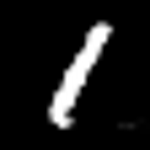
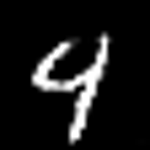
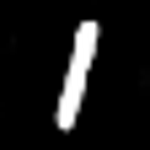
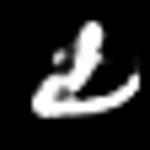

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4982 - g_loss: 1.4083
Epoch 38/50
547/547 [==============================] - ETA: 0s - d_loss: 0.5036 - g_loss: 1.4359


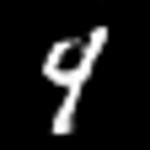
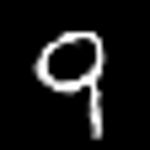
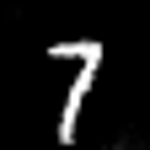
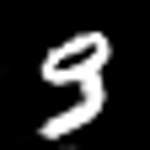


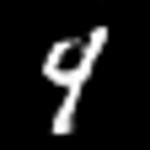
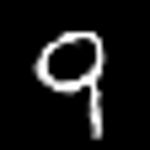
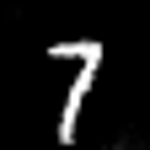
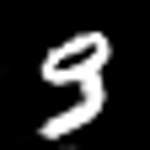

547/547 [==============================] - 41s 75ms/step - d_loss: 0.5036 - g_loss: 1.4359
Epoch 39/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4967 - g_loss: 1.4393


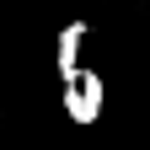
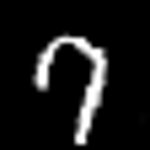
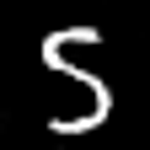
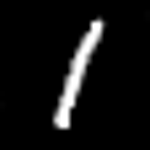


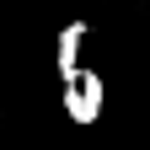
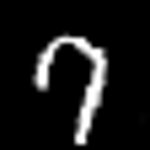
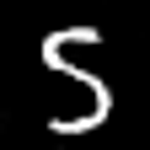
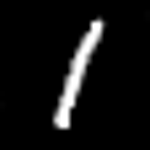

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4967 - g_loss: 1.4393
Epoch 40/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4962 - g_loss: 1.4492


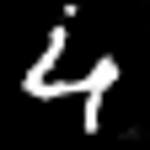
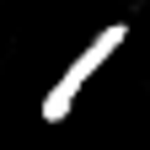
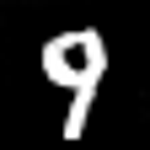
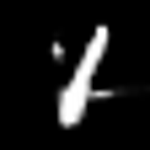


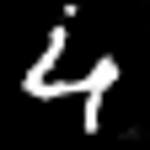
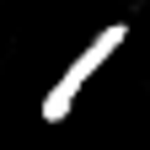
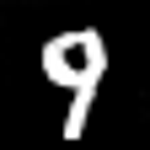
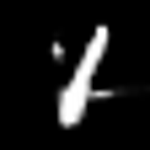

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4962 - g_loss: 1.4492
Epoch 41/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4959 - g_loss: 1.4511


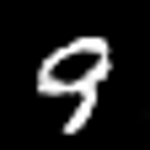
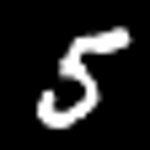
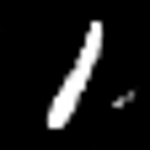
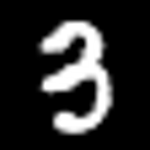


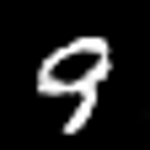
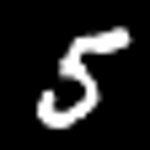
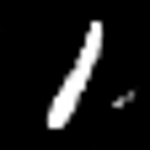
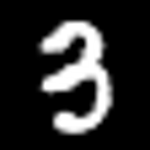

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4959 - g_loss: 1.4511
Epoch 42/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4931 - g_loss: 1.4537


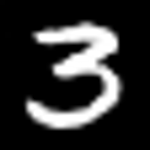
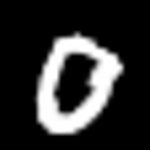
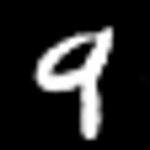
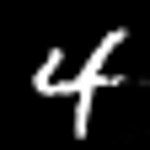


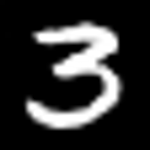
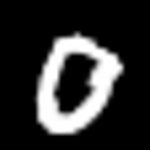
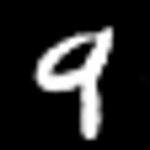
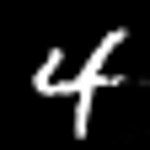

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4931 - g_loss: 1.4537
Epoch 43/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4923 - g_loss: 1.4693


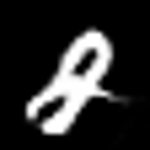
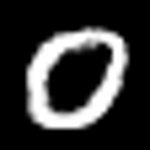
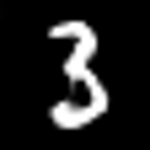
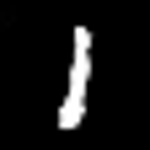


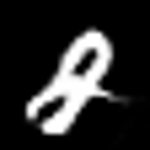
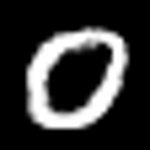
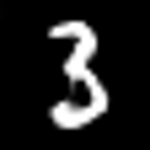
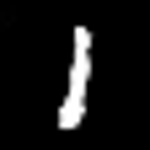

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4923 - g_loss: 1.4693
Epoch 44/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4890 - g_loss: 1.4662


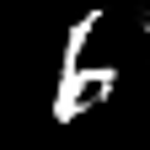
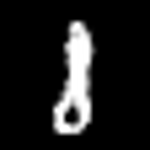
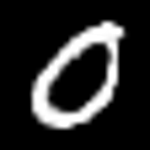
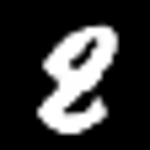


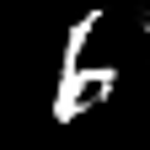
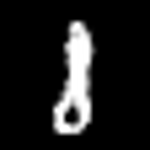
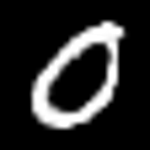
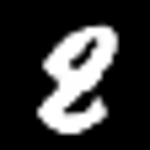

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4890 - g_loss: 1.4662
Epoch 45/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4869 - g_loss: 1.4795


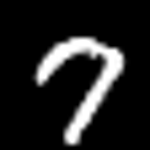
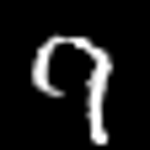
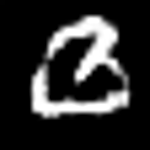
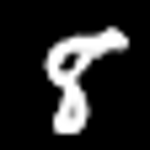


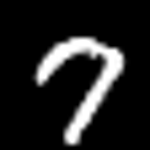
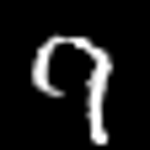
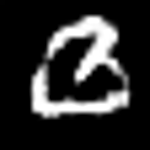
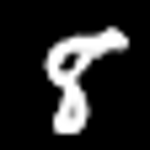

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4869 - g_loss: 1.4795
Epoch 46/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4889 - g_loss: 1.4861


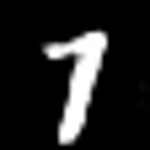
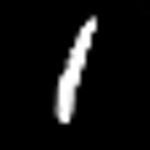
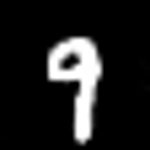
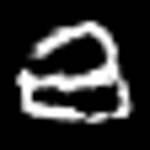


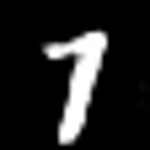
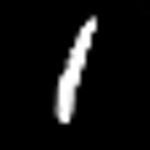
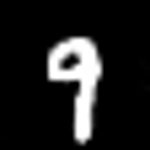
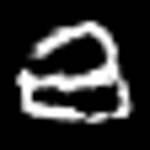

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4889 - g_loss: 1.4861
Epoch 47/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4886 - g_loss: 1.4820


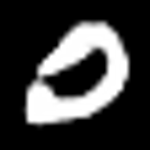
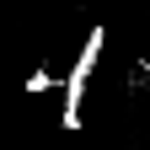
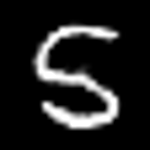
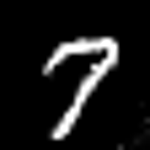


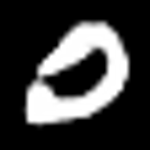
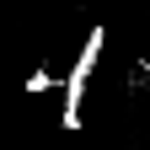
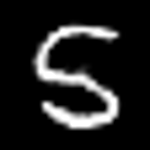
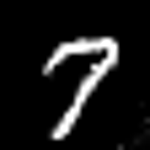

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4886 - g_loss: 1.4820
Epoch 48/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4840 - g_loss: 1.5077


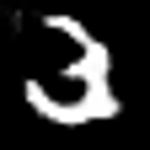
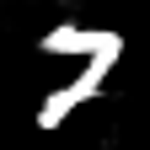
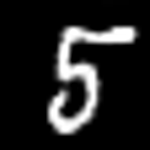
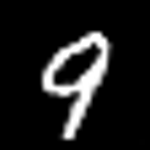


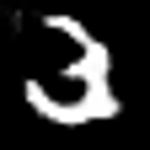
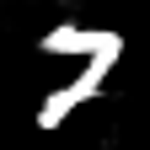
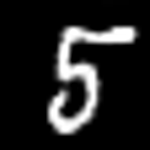
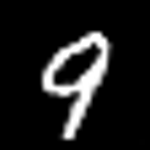

547/547 [==============================] - 41s 76ms/step - d_loss: 0.4840 - g_loss: 1.5077
Epoch 49/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4862 - g_loss: 1.5089


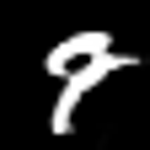
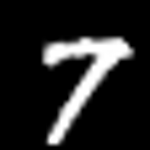
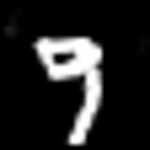
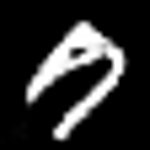


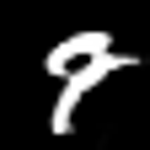
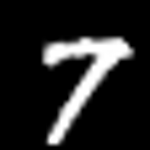
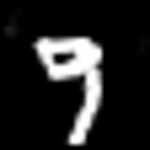
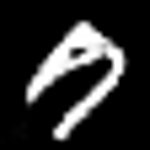

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4862 - g_loss: 1.5089
Epoch 50/50
547/547 [==============================] - ETA: 0s - d_loss: 0.4849 - g_loss: 1.5156


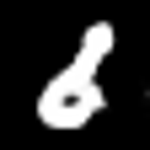
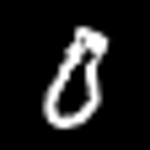
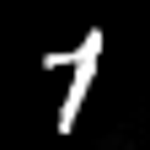
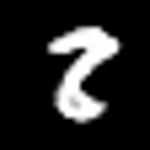


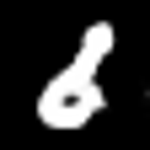
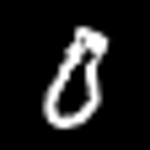
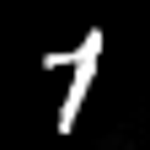
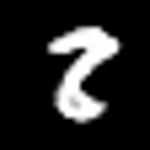

547/547 [==============================] - 41s 75ms/step - d_loss: 0.4849 - g_loss: 1.5156


In [ ]:
epochs = 50 #số epochs
latent_dim =100 #số chiều cho noises
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim)],verbose=1
    )


### 2. Sau khi train xong hãy viết một hàm sao cho khi đưa vào 4 lattent random vectors thì mô hình sẽ tạo ra 4 samples


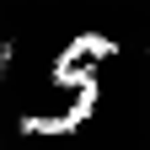
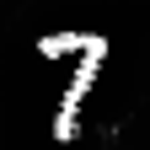
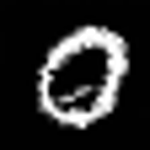
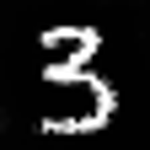


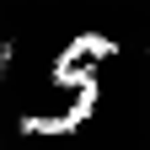
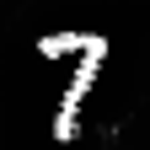
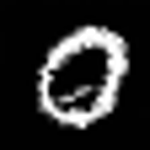
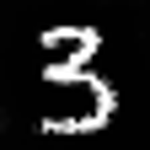

In [ ]:

def Generate_IMG(generator_model, num_imgs, latend_dim, num_seed):
  # tạo latent random vectors
  g = tf.random.Generator.from_seed(num_seed)
  random_latent_vectors = g.normal(shape=(num_imgs, latend_dim))
  # dùng Generator để tạo ra ảnh
  generated_images = generator_model(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  # lưu ảnh vào list
  list_img = []
  fig.suptitle('Image')
  for i in range(num_imgs):
    img = np.squeeze(generated_images[i], axis=2)
    list_img.append(img)
  # show ảnh
  ipyplot.plot_images(list_img)


Generate_IMG(generator_model = gan.generator ,
             num_imgs = 4, 
             latend_dim= 100, 
             num_seed= 20)